In [1]:
import numpy as np
import torch

# Data parameters
data_root = "./data/"
data_path = "nucleon_41x41x41_uint8.raw"
data_shape = (41, 41, 41)
data_type = np.uint8

# Fiting parameters
batch_size = 1024
num_workers = 3
num_epochs = 10
lr = 0.008
device = torch.device("cpu")
dtype = torch.float32

In [2]:
from pathlib import Path

from torch.utils.data import DataLoader
from volumetric_dataset import VolumetricDataset

# Create dataset and dataloader
dataset = VolumetricDataset(
    Path(data_root, data_path),
    data_shape,
    data_type,
    normalize_coords=True,
    normalize_values=True,
)
loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=num_workers)

In [4]:
from networks import INR_Base

# Create model
# kan_inr = INR_Base(
#     n_input_dims=3,
#     n_output_dims=1,
#     network="F-KAN",
#     n_hidden_layers=3,
#     n_neurons=64,
#     activation="SiLU",  # Base activation
# )
from networks import FKAN_Native

kan_inr = FKAN_Native(
    n_input_dims=3,
    n_output_dims=1,
    n_hidden_layers=3,
    n_neurons=64,
    activation="SiLU",  # Base activation
)
kan_inr

FKAN_Native(
  (fkan): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=24, out_features=64, bias=False)
        (base_linear): Linear(in_features=3, out_features=64, bias=True)
      )
      (1-2): 2 x FastKANLayer(
        (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=512, out_features=64, bias=False)
        (base_linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (3): FastKANLayer(
        (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=512, out_features=1, bias=False)
        (base_linear): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)

In [5]:
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm


kan_inr.to(device, dtype)
optimizer = AdamW(kan_inr.parameters(), lr=lr)
loss_fn = nn.functional.mse_loss
loader.dataset.return_indices = False

# Training loop
epoch_losses = []
for epoch in range(num_epochs):
    loss_total = 0.0
    for x, y_hat in tqdm(loader):
        x = x.to(device, dtype)
        y_hat = y_hat.to(device, dtype)
        y = kan_inr(x)
        loss = loss_fn(y, y_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    avg_loss = loss_total / len(loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

100%|██████████| 68/68 [00:03<00:00, 21.89it/s]


Epoch 1/10, Loss: 0.187785


100%|██████████| 68/68 [00:03<00:00, 21.03it/s]


Epoch 2/10, Loss: 0.006069


100%|██████████| 68/68 [00:02<00:00, 26.05it/s]


Epoch 3/10, Loss: 0.006106


100%|██████████| 68/68 [00:02<00:00, 24.61it/s]


Epoch 4/10, Loss: 0.004065


100%|██████████| 68/68 [00:02<00:00, 22.72it/s]


Epoch 5/10, Loss: 0.003564


100%|██████████| 68/68 [00:02<00:00, 25.94it/s]


Epoch 6/10, Loss: 0.003282


100%|██████████| 68/68 [00:02<00:00, 23.70it/s]


Epoch 7/10, Loss: 0.002047


100%|██████████| 68/68 [00:02<00:00, 25.20it/s]


Epoch 8/10, Loss: 0.001814


100%|██████████| 68/68 [00:02<00:00, 26.02it/s]


Epoch 9/10, Loss: 0.002618


100%|██████████| 68/68 [00:02<00:00, 27.60it/s]

Epoch 10/10, Loss: 0.001769


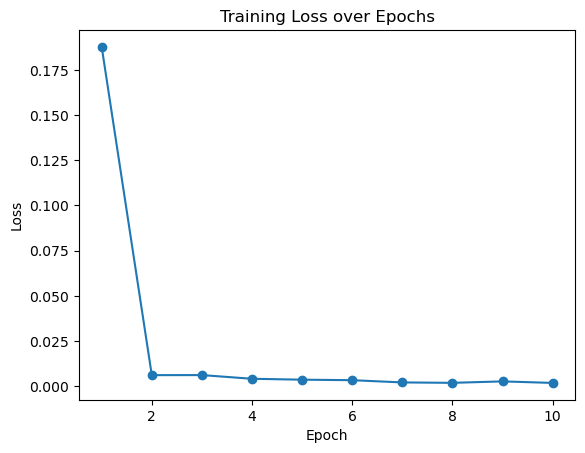

In [6]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
# Reconstruct the entire volume from the INR
kan_inr.eval()
with torch.no_grad():
    reconst_data = torch.zeros(dataset.data_shape, device=device, dtype=dtype)
    loader.dataset.return_indices = True
    for x, _, (i, j, k) in loader:
        x = x.to(device, dtype)
        y = kan_inr(x)
        for y_s, i_s, j_s, k_s in zip(y, i, j, k):
            reconst_data[i_s.item(), j_s.item(), k_s.item()] = y_s.item()

reconst_data = reconst_data.cpu().numpy()

# Rescale back to original range
data_min, data_max = dataset.data_range
data_range = data_max - data_min
reconst_data = reconst_data * data_range + data_min
reconst_data

array([[[ 16.9296    ,  13.218262  ,  -5.0580916 , ...,  -2.6829972 ,
          -4.123266  ,  -6.237565  ],
        [-11.320011  ,   1.9994842 ,  -5.746517  , ...,  -9.773284  ,
         -11.799498  , -14.47356   ],
        [ -4.937608  , -21.90909   ,   0.8508516 , ...,  -9.106646  ,
         -11.167158  , -13.242008  ],
        ...,
        [  1.3850734 ,  -0.43070197,  -1.4472892 , ...,   7.4994683 ,
           5.9330015 ,   3.0196037 ],
        [  1.8834529 ,  -0.07201123,  -1.8891373 , ...,   6.3927927 ,
           6.851159  ,   4.2134438 ],
        [  2.367243  ,   0.07668632,  -2.639452  , ...,   5.9112287 ,
           6.7778273 ,   5.156476  ]],

       [[-10.169152  ,  10.01762   , -18.699856  , ...,   0.30312395,
          -0.6716101 ,  -1.7296053 ],
        [ -1.1418054 ,  13.032682  ,  12.40812   , ...,  -4.79222   ,
          -7.067401  ,  -9.989466  ],
        [-15.816691  , -11.735768  ,  -0.3937168 , ..., -10.894548  ,
         -13.516131  , -16.642149  ],
        ...,


In [ ]:
import pyvista as pv

# Visualize ground truth and reconstructed data
gt_grid = pv.ImageData()
gt_grid.dimensions = np.array(dataset.data_shape) + 1
gt_grid.origin = (0, 0, 0)
gt_grid.spacing = (1, 1, 1)
gt_grid.cell_data["values"] = dataset.data.flatten(order="F")
reconst_grid = pv.ImageData()
reconst_grid.dimensions = np.array(dataset.data_shape) + 1
reconst_grid.origin = (0, 0, 0)
reconst_grid.spacing = (1, 1, 1)
reconst_grid.cell_data["values"] = reconst_data.flatten(order="F")
p = pv.Plotter(shape=(1, 2))
# p.add_mesh(gt_grid.contour(), scalars="values")
p.subplot(0, 1)
# p.add_mesh(reconst_grid.contour(), scalars="values")
p.show()()